# Imports

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats import uniform
import itertools
from tqdm import tqdm
from functools import reduce
import matplotlib

In [57]:
sns.set(context="paper", style="ticks")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

TICKS_SIZE = 6
AXES_SIZE = 6.5
TINY_SIZE = 4
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=AXES_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=AXES_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICKS_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=TICKS_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=AXES_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.rc('axes', titlepad=1)
plt.rc('axes', labelpad=1)
plt.rc('lines', linewidth=0.5)
plt.rc('axes', linewidth=0.5)
plt.rc('xtick.major', width=0.25, size=1.5, pad=1)
plt.rc('xtick.minor', width=0.25, size=1.5, pad=1)
plt.rc('ytick.major', width=0.25, size=1.5, pad=1)
plt.rc('ytick.minor', width=0.25, size=1.5, pad=1)

# Step 1: Feature matrix generation

## Step 1 - Stage I: construction of core factors

This stage consists of 4 steps:

(I.I) We applied hierarchical clustering on the weight-loss correlation matrix. As the hierarchical clustering clearly manifested 15 prevalent patterns, the genes were divided into 15 clusters based on the subtrees in this hierarchical clustering solution.

(I.II) As each of the 15 clusters has a unique relevance to phenotypic diversity, in step I.II-I.III we aimed to represent each of these cluster – in each of the 5 time points (the 3h p.i. time point was omitted from the construction of the map starting from this step) – as a separate core factor.
To that end, for each cluster of genes and each time point, we calculated a ‘gene-gene correlation matrix’ (using Pearson’s correlation coefficients; using only the genes in the cluster and using expression data of one time point), a total of 75 gene-gene correlation matrices.

(I.III) For an unbiased analysis, we aimed to use the same number of genes in each gene-gene correlation matrix. To that end, we calculated a ‘core score’ for each gene, defined as the upper quartile of its correlations to other genes in the same gene-gene correlation matrix. Retaining only genes with a significant core score (Bonferroni-corrected empirical p-value < 0.05), the smallest gene-gene correlation matrix included 30 genes.
We therefore used a set of exactly 30 genes with the top core scores for the representation of each gene-gene correlation matrix.
Overall, the output of step I.III is a collection of 75 sets of genes, each of which consists of 30 core genes. We refer to these 75 sets of core genes as *‘core factors’*.

(I.IV) Finally, for each individual mouse, we calculated the average expression across the 30 core genes of each core factor. Thus, each mouse is associated with a vector of 75 ‘core values’, each of which is the average of 30 expression values in a single core factor.

### Step 1, stage I.I: generation of the weight-loss correlation matrix

We first calculated a matrix for the Pearson’s correlation between the weight loss phenotype at 96h p.i. and the expression of each gene across all mouse strains, where each entry eij represents the correlation between the weight loss at 96h p.i. and expression of gene i in time point j across all strains (a ’weight-loss correlation matrix’, with 24,500 rows for genes and 6 columns for the different time points).

#### Read input files

In [2]:
# Read the weight loss matrix
df_weights_4 = pd.read_excel("inputs/weight_loss96.xlsx", index_col=0)

In [125]:
def read_gene_exp(gene_exp_path, drop_duplicates=False, transpose=True):
    gene_exp = pd.read_csv(gene_exp_path, index_col=0)
    # Remove genes with only zeros
    gene_exp = gene_exp[(gene_exp.T != 0).any()].transpose()
    # Drop duplicates
    if drop_duplicates:
        gene_exp = gene_exp.T[~gene_exp.T.index.duplicated(keep='first')].T
    # Apply log transformation on the remaining genes
    gene_exp = np.log(gene_exp + 0.000000000001)
    if transpose:
        gene_exp = gene_exp.T
    return gene_exp

In [ ]:
# Read the gene expression matrices
time_points = [0, 3, 7, 24, 48, 96]
columns = None
exp_dfs_list = []

for t in time_points:
    cur_exp_df = read_gene_exp(f"inputs/gene_expression/gene_exp{t}.csv", drop_duplicates=True, transpose=False)
    cur_exp_df.index = cur_exp_df.index.map(lambda x: x.split(".")[0].split("_")[0])

    exp_dfs_list.append(cur_exp_df)
    if columns is None:
        columns = cur_exp_df.columns
    else:
        columns = columns.intersection(cur_exp_df.columns)

# Only check genes that were in all the data sets
exp_dfs = {}
for t, cur_exp_df in zip(time_points, exp_dfs_list):
    cur_exp_df = cur_exp_df[columns]
    exp_dfs[f"{t}_hours"] = pd.pivot_table(cur_exp_df, index=cur_exp_df.index)

#### Calculate the gene expression - weight loss correlation matrix

In [ ]:
res = []
for x_name in exp_dfs:
    title = f"phenotype_4_days_exp_{x_name}"
    x_aligned, y_aligned = exp_dfs[x_name].align(df_weights_4, axis=0, join='inner')
    res.append(x_aligned.apply(lambda x: pd.Series(scipy.stats.pearsonr(x, y_aligned['weight_loss_96']), index=['r_%s' % title, 'p_value_%s' % title]), axis=0).T)

In [6]:
weight_loss_cor = reduce(lambda left,right: pd.merge(left, right, how="inner", left_index=True, right_index=True), res)

In [7]:
weight_loss_cor.shape

(24486, 12)

In [8]:
weight_loss_cor.head()

,r_phenotype_4_days_exp_0_hours,p_value_phenotype_4_days_exp_0_hours,r_phenotype_4_days_exp_3_hours,p_value_phenotype_4_days_exp_3_hours,r_phenotype_4_days_exp_7_hours,p_value_phenotype_4_days_exp_7_hours,r_phenotype_4_days_exp_24_hours,p_value_phenotype_4_days_exp_24_hours,r_phenotype_4_days_exp_48_hours,p_value_phenotype_4_days_exp_48_hours,r_phenotype_4_days_exp_96_hours,p_value_phenotype_4_days_exp_96_hours
geneSymbol,,,,,,,,,,,,
0610005C13Rik,0.137580,0.460481,-0.305298,0.107294,-0.029496,0.881558,0.097173,0.603039,-0.218463,0.237724,0.078885,0.657431
0610007C21Rik,-0.259758,0.158187,0.006451,0.973507,-0.101547,0.607132,0.183896,0.322032,-0.141773,0.446792,-0.054048,0.761442
0610007L01Rik,-0.022330,0.905090,-0.039700,0.837987,0.286808,0.138942,-0.298036,0.103428,-0.284554,0.120783,0.073260,0.680522
0610007P08Rik,0.034104,0.855477,0.121865,0.528857,-0.242978,0.212810,0.186841,0.314205,-0.127007,0.495967,-0.005604,0.974905
0610007P14Rik,0.010178,0.956665,-0.391935,0.035487,-0.159453,0.417662,-0.082988,0.657160,-0.064614,0.729844,0.418969,0.013653


In [9]:
output_path = "outputs/gene_expression_weight_loss_corr_df.xlsx"
weight_loss_cor.to_excel(output_path)

In [10]:
weight_loss_cor = weight_loss_cor.filter(like="r_phenotype_4_days_exp")
weight_loss_cor.columns = [0, 3, 7, 24, 48, 96]
weight_loss_cor.head()

,0,3,7,24,48,96
geneSymbol,,,,,,
0610005C13Rik,0.137580,-0.305298,-0.029496,0.097173,-0.218463,0.078885
0610007C21Rik,-0.259758,0.006451,-0.101547,0.183896,-0.141773,-0.054048
0610007L01Rik,-0.022330,-0.039700,0.286808,-0.298036,-0.284554,0.073260
0610007P08Rik,0.034104,0.121865,-0.242978,0.186841,-0.127007,-0.005604
0610007P14Rik,0.010178,-0.391935,-0.159453,-0.082988,-0.064614,0.418969


#### Filtering out genes

Focusing on genes in which the correlation in at least one time point is high (>5th percentile or < 95th percentile), we selected those genes in which two consecutive time points had strong correlation at the same direction (>0.15 or < -0.15; the 0.15 cutoff was selected because it is the median across all genes at all time points).
Overall, out of 24,500 genes, 5075 genes were selected and were subsequently used for the construction of a map

In [12]:
weight_loss_cor = weight_loss_cor[~pd.isna(weight_loss_cor).any(axis=1)]

##### Genes in which the correlation in at least one time point is high

In [13]:
tresholds = weight_loss_cor.quantile([0.05, 0.95])
tresholds

,0,3,7,24,48,96
0.05,-0.300374,-0.318998,-0.282419,-0.361395,-0.323942,-0.396232
0.95,0.306082,0.243686,0.295389,0.313330,0.298580,0.451306


In [14]:
chosen_genes = weight_loss_cor.index[((weight_loss_cor < tresholds.loc[0.05]) | (weight_loss_cor > tresholds.loc[0.95])).any(axis=1)]
chosen_genes

Index(['0610007P14Rik', '0610007P22Rik', '0610008F07Rik', '0610009B14Rik',
       '0610009D07Rik', '0610009E02Rik', '0610011F06Rik', '0610031J06Rik',
       '0610037P05Rik', '0610039K10Rik',
       ...
       'n-R5s1', 'n-R5s102', 'n-R5s115', 'n-R5s122', 'n-R5s130', 'n-R5s136',
       'n-R5s46', 'snoU109', 'snoU6-53', 'snoU89'],
      dtype='object', name='geneSymbol', length=11117)

In [15]:
weight_loss_cor_10per = weight_loss_cor.loc[chosen_genes]

#####  Choosing genes in which two consecutive time points had strong correlation at the same direction

In [16]:
def check_direction_and_diff(x):
    x_len = x.shape[0]

    # Define a window around the max value for the current gene (x)
    x.index = range(x_len)
    max_pos = x.abs().idxmax()
    window = x[max(0, max_pos-1):min(x_len, max_pos+2)]

    # Check if any two values in the window have the same sign and are both larger than 0.15
    use_gene = ((np.sign(window).rolling(2).apply(lambda y: y.iloc[0] == y.iloc[1]).fillna(False).astype(bool)) &
                (window.rolling(2).apply(lambda x: (np.abs(x) > 0.15).all()))).any()

    return use_gene

In [17]:
chosen_genes = weight_loss_cor_10per.index[weight_loss_cor_10per.apply(check_direction_and_diff, axis=1)]
chosen_genes.shape

(5075,)

#### Clustering the matrix

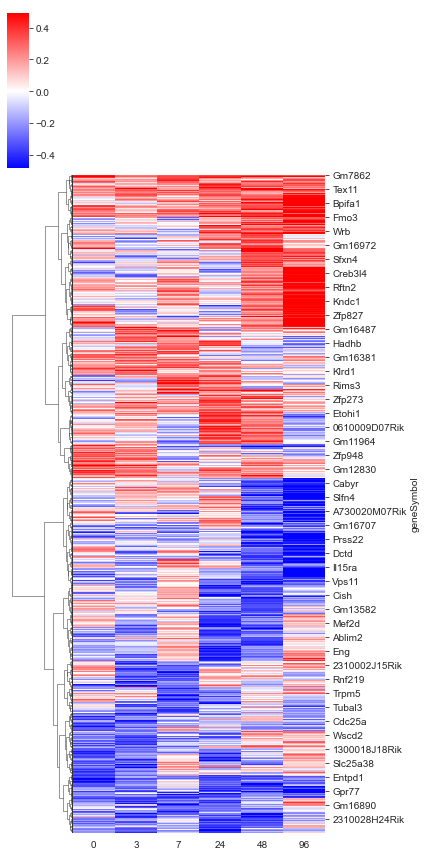

In [18]:
res = sns.clustermap(weight_loss_cor.loc[chosen_genes],
                     figsize=(6,12),
                     col_cluster=False,
                     method="ward",
                     center=0,
                     robust=True,
                     cmap = "bwr")

In [19]:
gene_order = chosen_genes[res.dendrogram_row.reordered_ind]

In [20]:
output_path = "outputs/gene_expression_weight_loss_corr_df_filtered.xlsx"
weight_loss_cor.loc[gene_order].to_excel(output_path)

Cutting the dendogram based on manual inspection – i.e., not at the same level for all clusters.

In [ ]:
unified_df = pd.read_excel("inputs/gene_expression_weight_loss_corr_df_filtered_clustered.xlsx", index_col=0)

In [23]:
unified_df.head()

,weight_cluster,weight_num,r_weight_96_exp_0,r_weight_96_exp_3,r_weight_96_exp_7,r_weight_96_exp_24,r_weight_96_exp_48,r_weight_96_exp_96
Cela3b,1,44,0.153594,0.226135,0.425616,0.265515,0.148212,0.293054
Cd164l2,1,302,0.173027,0.362678,0.554958,0.373151,0.349343,0.511039
Esrrg,1,250,0.225795,0.214819,0.132345,0.131580,0.351912,0.462074
AW551984,1,320,0.322147,0.297463,0.315270,0.410559,0.616262,0.563751
Mapk12,1,185,0.054484,0.240214,0.142040,0.233254,0.356273,0.518099


Visualizing the final clustering solution:

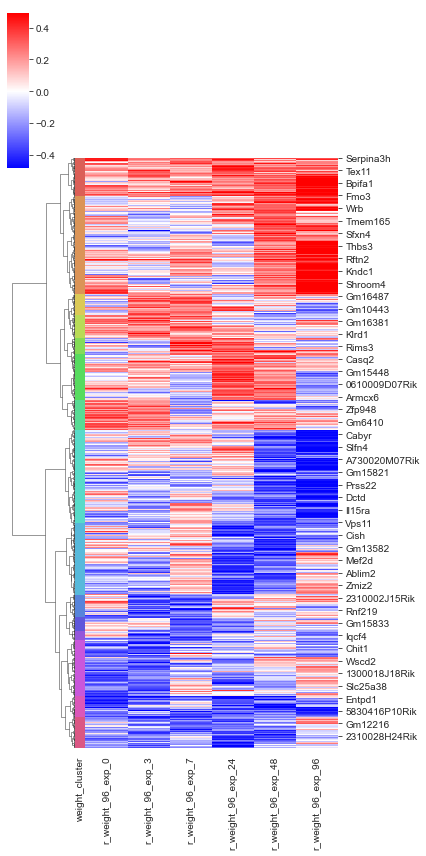

In [24]:
palette15 = itertools.cycle(sns.color_palette("hls", 15))
lut = dict(zip(range(1,16), palette15))
row_colors = unified_df["weight_cluster"].map(lut)

cg = sns.clustermap(unified_df.iloc[:, 2:],
                 figsize=(6,12),
                 col_cluster=False,
                 method="ward",
                 center=0,
                 row_colors=row_colors,
                 robust=True,
                 cmap = "bwr")

plt.savefig("outputs/gene_expression_weight_loss_corr_df_filtered_clustered.pdf",
            transparent=True, bbox_inches="tight")

### Step 1, stages I.II-I.IV: generation of the gene-gene correlation matrices, choosing cores and calculating the core-values matrix

#### Read inputs and define relevant functions

To avoid a bias toward early time points, the data at 3h p.i. was omitted from all following steps.

In [21]:
time_points = [0, 7, 24, 48, 96]

In [25]:
gene_exp_list = [read_gene_exp(f"inputs/gene_expression/gene_exp{t}.csv", drop_duplicates=True) for t in time_points]

In [26]:
def calc_within_cluster_corr(df_full, time_df, cluster_num, cluster_field):
    """
    Calculates the correlations between genes in a specific cluster
    :param df_full: A data frame with clustering information for each gene
    :param time_df: A data frame with gene expression at a certain time point
    :param cluster_num: An integer indicating the cluster we wish to correlate
    :param cluster_field: A string indicating the name of the cluster column in df_full
    :return: in-cluster correlations data frame
    """
    weight_cluster_genes = df_full.query(f"{cluster_field} == {cluster_num}").index.unique()
    cluster_df = time_df.reindex(weight_cluster_genes)
    cluster_df = cluster_df[~pd.isna(cluster_df).any(axis=1)]
    corr_df = pd.DataFrame(np.corrcoef(cluster_df), columns=cluster_df.index, index=cluster_df.index)
    return corr_df

#### Calculate the correlations between genes of the same cluster

In [27]:
# Only check genes that were in all the data sets
shared_index = gene_exp_list[0].index
for cur_exp_df in gene_exp_list[1:]:
    shared_index = shared_index.intersection(cur_exp_df.index)
print("shared_index shape:", shared_index.shape)

# Go over all the clusters and time points (75 iterations)
corr_df_dict = {}
for t, cur_gene_exp in zip(time_points, gene_exp_list):
    corr_df_dict[t] = {}
    for i in range(1, 16):
        corr_df_dict[t][i] = calc_within_cluster_corr(unified_df, cur_gene_exp.loc[shared_index], i, "weight_cluster")

shared_index shape: (24631,)


##### Calculate the correlations between core genes of different clusters

###### Functions

In [28]:
def choose_core_genes(cur_corr_df_dict, gene_num=30, quantile=0.75, clusters_num=15):
    gene_list = []
    for i in range(1, clusters_num+1):
        corr_df = cur_corr_df_dict[i]
        gene_list += list(corr_df.quantile(quantile).nlargest(gene_num).index)
    return gene_list

In [29]:

def get_core_genes_exp_matrix(cur_gene_exp, cur_corr_df_dict, gene_num=30, quantile=0.75, df=unified_df):
    gene_list = choose_core_genes(cur_corr_df_dict, gene_num=gene_num, quantile=quantile)
    res_df = cur_gene_exp.loc[gene_list]
    res_df["cluster"] = df.loc[gene_list, "weight_cluster"]
    res_df.set_index("cluster", append=True, drop=True, inplace=True)
    return res_df

###### Calculate the correlations to create the **core-values matrix** (step 1 - stage I.IV)

In [75]:
res_df_list = [get_core_genes_exp_matrix(gene_exp_list[i], corr_df_dict[t], df=unified_df) for i, t in enumerate(time_points)] # These are the core-values matrices (a list of matrices by time point)

###### Calculate the mean expression of each core (in each time point)

In [31]:
res_df_mean_list = [res_df.groupby(level=1).mean().assign(time=t).set_index("time", append=True, drop=True) for res_df, t in zip(res_df_list, time_points)]
parameter_table = pd.concat(res_df_mean_list, sort=True)

In [32]:
core_genes_all_time_points = res_df_list[0].index
for res_df in res_df_list[1:]:
    core_genes_all_time_points = core_genes_all_time_points.union(res_df.index)
core_genes_all_time_points = core_genes_all_time_points.unique()

In [33]:
# Visualize the Gene-Gene correlation matrices (step 1, stage I.II)
fig, axes = plt.subplots(nrows=15, ncols=5, figsize=(2, 4))
for i, (t, cluster_num) in enumerate(itertools.product(time_points, range(1, 16))):
    curr_df = corr_df_dict[t][cluster_num]
    # Cluster the heatmap
    Z = scipy.cluster.hierarchy.linkage(curr_df, method="ward", optimal_ordering=True)
    leaves_list = scipy.cluster.hierarchy.leaves_list(Z)
    curr_df_ordered = curr_df.iloc[leaves_list, leaves_list]

    # Plot
    ax = axes[(cluster_num-1) % 15, (time_points.index(t))]
    sns.heatmap(curr_df_ordered, cmap="bwr", vmin=-1, vmax=1,
                ax=ax, yticklabels=False, xticklabels=False,
                cbar=False, square=True)

plt.savefig("outputs/inter_cluster_correlations.png", dpi=600, transparent=True, bbox_inches="tight")
plt.close()

In [34]:
core_genes_all_time_points.shape

(1162,)

In [35]:
parameter_table.head()

,,1061A,111A,111B,1488A,1513A,188A,1912A,211B,2126A,2131A,...,5021A,5022A,5023A,57B,6009A,6012A,6018A,6020A,72A,B6
cluster,time,,,,,,,,,,,,,,,,,,,,,
1,0,NaN,2.032498,NaN,1.401456,NaN,1.443301,1.786317,1.849987,1.641028,NaN,...,1.658103,1.337163,1.491089,1.738172,1.696653,1.726595,2.233413,2.056103,1.361127,2.224821
2,0,NaN,2.421869,NaN,2.226548,NaN,2.546171,2.525580,2.599280,2.558189,NaN,...,2.208467,2.327059,2.310878,2.429053,2.336920,2.422485,2.611747,2.555888,2.384199,2.355071
3,0,NaN,-5.087577,NaN,-5.380300,NaN,-5.529247,-4.448257,-5.511634,-5.280342,NaN,...,-2.466512,-5.493727,-4.501756,-6.410843,-3.642464,-4.601724,-5.274682,-6.189929,-2.425703,-1.595735
4,0,NaN,-0.654126,NaN,-1.536342,NaN,-1.149017,-0.472630,0.087892,0.243620,NaN,...,1.399449,-0.837015,0.368062,0.163458,0.240051,-1.512749,-0.327914,0.548108,0.088618,1.180585
5,0,NaN,-2.283482,NaN,-3.370660,NaN,-5.892273,-3.137165,-4.127008,-5.809897,NaN,...,-3.992080,-3.332568,-1.335263,-3.969171,-2.332762,-4.213236,-2.074549,-0.942435,-4.819735,-2.926837


## Step 1 - Stage II: calculating the core-centered co-expression matrix

We constructed a feature matrix for the co-expression between each gene and each core factor in a specific time point t.

Formally, each entry fij in the feature matrix is the Pearson’s correlation between the value of core factor j and the expression of gene i across all mouse samples of a certain time point t.

We refer to this matrix as a ‘co-expression feature matrix’ (of time t).

In analysis of these matrices for the different time points, we found a clear signature of two distinct patterns when using t = 96h whereas the other time points mainly manifest a single pattern.

We therefore selected to use the 96h co-expression feature matrix in this study.

In [36]:
def cluster_param_feature(cur_gene_exp, parameter_table, lines_order,
                          df=unified_df, threshold=-1,
                          core_genes=None, corr_method="pearson",
                          plot=False, full=False, **kwargs):
    a = parameter_table[lines_order.index]
    if full:
        b = cur_gene_exp[lines_order.index]
    else:
        b = cur_gene_exp.loc[df.index, lines_order.index]

    param_feature_corr_list = []
    for feature in tqdm(b.iterrows()):
        param_feature_corr_list.append(a.corrwith(feature[1], axis=1, method=corr_method))
    param_feature_df = pd.concat(param_feature_corr_list, axis=1)
    param_feature_df.columns = b.index
    param_feature_df = param_feature_df[param_feature_df.columns[~pd.isna(param_feature_df).any()]]

    param_feature_df = param_feature_df[param_feature_df.abs().median(axis=1) > threshold]

    if plot and not full:
        if "time_points" in kwargs:
            time_points = kwargs["time_points"]
        else:
            time_points = [0, 7, 24, 48, 96]

        if "method" in kwargs:
            method = kwargs["method"]
        else:
            method = "average"

        if "metric" in kwargs:
            metric = kwargs["metric"]
        else:
            metric = "euclidean"

        if "col_colors_fields" in kwargs:
            col_colors_fields = kwargs["col_colors_fields"]
        else:
            # Color the columns by gene expression-weight loss correlations (weight loss at 96h p.i.
            # and gene expression from multiple time points
            col_colors_fields=["r_weight_96_exp_0",
                               "r_weight_96_exp_7",
                               "r_weight_96_exp_24",
                               "r_weight_96_exp_48",
                               "r_weight_96_exp_96"]


        # Color the rows by the original cluster (the cluster of the relevant core) and time points
        palette5 = itertools.cycle(sns.color_palette("husl", 5))
        lut = dict(zip(time_points, palette5))
        time_colors = list(map(lambda x: lut[x], param_feature_df.index.get_level_values(1)))

        palette15 = itertools.cycle(sns.color_palette("hls", 15))
        lut2 = dict(zip(range(1,16), palette15))
        cluster_colors = list(map(lambda x: lut2[x], param_feature_df.index.get_level_values(0)))

        # Color the columns
        palette2 = itertools.cycle(sns.color_palette("Greys", 2))
        lut3 = dict(zip([True, False], palette2))
        core_colors = list(map(lambda x: lut3[x], param_feature_df.columns.map(lambda y: True if y in core_genes else False)))
        col_colors = [core_colors]

        for col in col_colors_fields:
            corr_range = [i/10.0 for i in range(-10, 11)]
            n = len(corr_range)
            palette = itertools.cycle(sns.color_palette("bwr", n))
            cur_lut = dict(zip(corr_range, palette))
            cur_weight_corr_colors = list(map(lambda x: cur_lut[x],
                                            df.loc[param_feature_df.columns, col].round(1)))
            col_colors.append(cur_weight_corr_colors)

        cg = sns.clustermap(param_feature_df, vmin=-1, vmax=1, cmap="bwr", yticklabels=True,
                            row_colors=[time_colors, cluster_colors], col_colors=col_colors,
                            figsize=(15,15), method=method, metric=metric)

        # Draw the legend bar for the classes
        for label in time_points:
            cg.ax_col_dendrogram.bar(0, 0, color=lut[label],
                                     label=label, linewidth=0)
        cg.ax_col_dendrogram.legend(loc="center", ncol=4)

        for label in range(1,16):
            cg.ax_col_dendrogram.bar(0, 0, color=lut2[label],
                                     label=label, linewidth=0)
        cg.ax_col_dendrogram.legend(loc="center", ncol=4)

        # Adjust the postion of the main colorbar for the heatmap
        cg.cax.set_position([.97, .2, .03, .45])

    return param_feature_df

In [37]:
lines_order = df_weights_4.loc[parameter_table.columns[~pd.isna(parameter_table).any()]].sort_values(by="weight_loss_96")

In [ ]:
for t, cur_gene_exp in zip(time_points[:-1], gene_exp_list[:-1]):
    cur_param_feature_df = cluster_param_feature(cur_gene_exp, parameter_table, lines_order,
                                                 df=unified_df,core_genes=core_genes_all_time_points, plot=True)

    plt.savefig(f"outputs/param_feature_df{t}.pdf", transparent=True, bbox_inches="tight")

5075it [01:07, 75.57it/s]


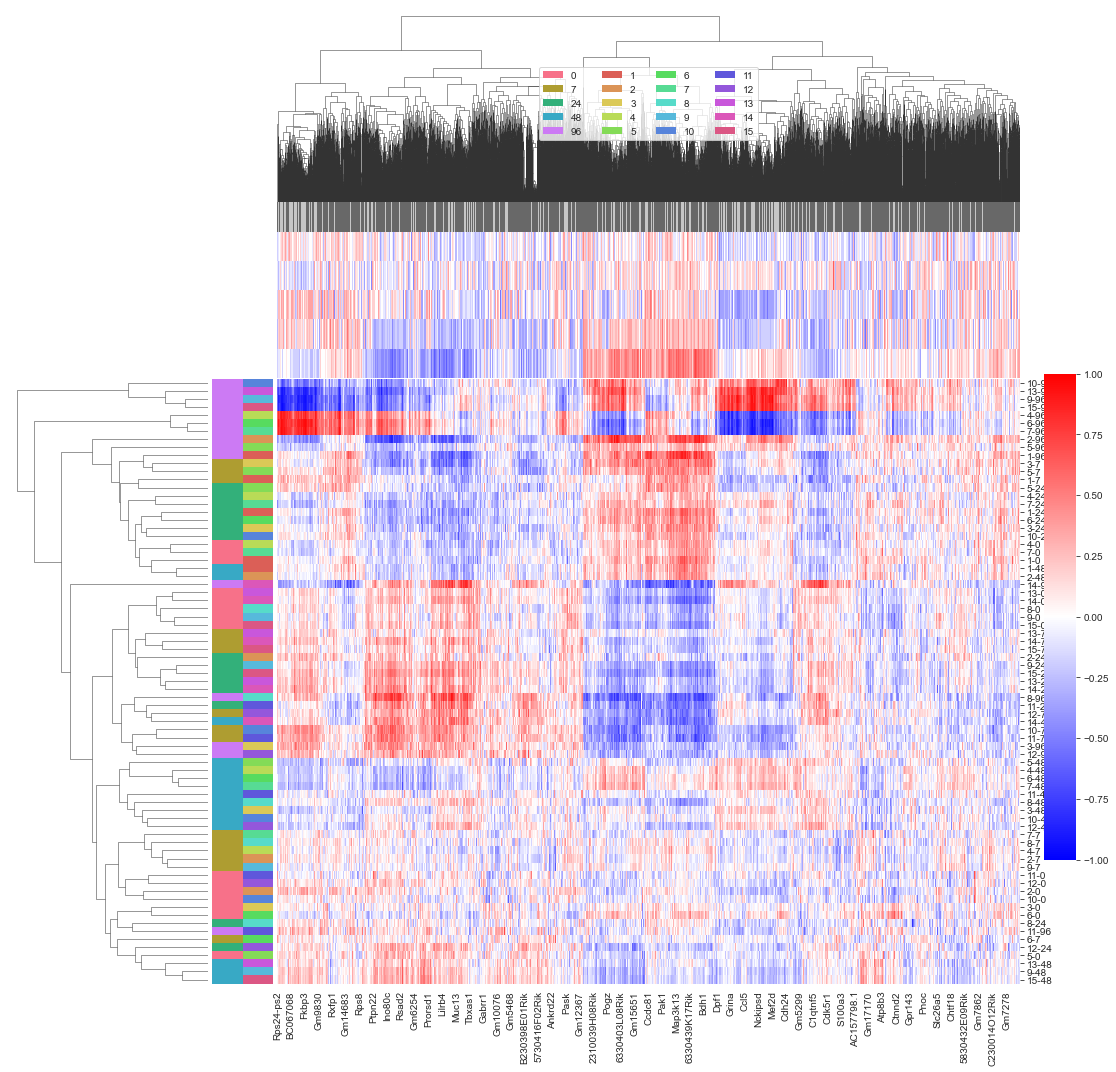

In [38]:
# The core-centered co-expression matrix
param_feature_df96 = cluster_param_feature(gene_exp_list[-1], parameter_table, lines_order,
                                          df=unified_df,core_genes=core_genes_all_time_points, plot=True)

plt.savefig("outputs/param_feature_df96.pdf", transparent=True, bbox_inches="tight")
# Three genes were omitted due to a lack of information at the relevant time point.

In [39]:
# Calculate the core-centered co-expression matrix for all the genes (without filtering out genes),
# so we can use cast the genes that won't be used for dimension reduction using the trained model
param_feature_df96_full = cluster_param_feature(gene_exp_list[-1], parameter_table, lines_order, full=True)

26820it [05:46, 77.31it/s]


In [40]:
output_path = "outputs/param_feature_df96.xlsx"
param_feature_df96.to_excel(output_path)

In [41]:
output_path_full = "outputs/param_feature_df96_full.csv"
param_feature_df96_full.to_csv(output_path_full)

# Step 2- Dimension reduction

Using the feature matrix from step 1 as input, we trained an Auto Encoder neural network with a two-dimensional bottleneck layer and a sigmoid activation function with MSE loss.

We focused on a two-dimensional map, since the feature map showed a clear signature of two programs.

We used the bottleneck layer as the two-dimensional representation, referred to here as a ‘map’.

After the generation of the map, the genes that were filtered out in the preprocessing step were projected onto the map using the trained network, providing a full model that includes all genes.

## Train the model

In [42]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense
from keras.models import Model, model_from_json

In [43]:
input_df = param_feature_df96
if input_df.shape[0] < input_df.shape[1]:
    input_df = input_df.T

scaler = MinMaxScaler()
scaler.fit(input_df)
X = scaler.transform(input_df)

activation = "sigmoid"

input_dim = X.shape[1]
encoding_dim = 2
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation=activation)(input_img)
decoded = Dense(input_dim, activation=activation)(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X, X,
                          epochs=50,
                          batch_size=16,
                          shuffle=True,
                          validation_split=0.1,
                          verbose = 0)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X)

input_res = pd.DataFrame(encoded_data, index=input_df.index, columns=["comp1", "comp2"])

## The following part is based on the code from here: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# serialize model to JSON
model_json = encoder.to_json()
with open("outputs/encoder_model.json", "w") as json_file: #TODO: change the paths that have dates on to the ones we originally ysed
    json_file.write(model_json)
# serialize weights to HDF5
encoder.save_weights("outputs/encoder_model.h5")
print("Saved model to disk")

/Users/gal/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/gal/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
2022-08-07 13:13:40.755129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


159/159 [==============================] - 0s 524us/step
Saved model to disk


## Casting the remaining genes onto the gene map

In [45]:
param_feature_df96_full = pd.read_csv("outputs/param_feature_df96_full.csv",
                                      index_col=0).T
param_feature_df96_full = param_feature_df96_full.drop("time", axis=0)

In [46]:
param_feature_df96_full.head()

cluster,1,2,3,4,5,6,7,8,9,10,...,6,7,8,9,10,11,12,13,14,15
Gnai3,-0.064261,0.376051,0.009762,-0.025540,0.082808,-0.224324,-0.143304,0.198082,0.190627,0.145921,...,0.913856,0.944989,0.237574,-0.879084,-0.666255,0.028020,0.139329,-0.904191,-0.295675,-0.902747
Cdc45,-0.324907,0.182442,-0.183826,-0.218356,-0.007393,-0.287442,-0.231313,0.468626,0.312541,0.133860,...,0.450243,0.361632,0.189712,-0.365710,-0.030805,-0.052177,0.308805,-0.300985,0.068918,-0.310624
H19,0.154977,-0.388616,0.196756,0.069614,0.233327,0.170939,0.152056,-0.232574,-0.193937,-0.373499,...,-0.481851,-0.381038,-0.146606,0.469267,0.067391,-0.244318,-0.299270,0.381291,0.074212,0.418141
Scml2,0.079926,0.311738,-0.007580,-0.132932,-0.219570,-0.172227,-0.199908,0.134024,0.061870,-0.033352,...,0.585396,0.605021,-0.230058,-0.564976,-0.270182,0.006042,0.005898,-0.442618,-0.534842,-0.552281
Apoh,-0.372086,-0.107668,0.271569,0.070649,0.067151,0.046239,0.161093,0.149450,0.086820,-0.256955,...,0.133378,0.115670,0.226365,-0.191961,-0.159251,0.029464,0.019652,-0.217919,0.252429,-0.160644


In [47]:
# load json and create model - using the original weights
json_file = open('inputs/encoder_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
encoder = model_from_json(loaded_model_json)
# load weights into new model
encoder.load_weights("inputs/encoder_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [48]:
X2 = scaler.transform(param_feature_df96_full)
encoded_data_full = encoder.predict(X2)

830/830 [==============================] - 0s 499us/step


In [49]:
param_feature_df96_full_res = pd.DataFrame(encoded_data_full, index=param_feature_df96_full.index, columns=["comp1", "comp2"])

In [50]:
param_feature_df96_full_res.head()

,comp1,comp2
Gnai3,0.318572,0.112684
Cdc45,0.689717,0.236563
H19,0.526025,0.749368
Scml2,0.204956,0.294805
Apoh,0.706068,0.270699


In [51]:
output_path = "outputs/param_feature_df96_full_res.xlsx"
param_feature_df96_full_res.to_excel(output_path)

## Rotate the gene map

In [52]:
def rotate_space(gene_space, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    comp1 = gene_space.apply(lambda x: np.linalg.solve(R, x)[0], axis=1)
    comp2 = gene_space.apply(lambda x: np.linalg.solve(R, x)[1], axis=1)
    df_res = pd.concat([comp1, comp2], axis=1)
    df_res.columns = ["comp1", "comp2"]
    df_res = df_res - df_res.median()
    return df_res

gene_map = rotate_space(param_feature_df96_full_res, 360 - 45)
gene_map.columns = ["R", "T"]

In [53]:
gene_map.to_excel("outputs/gene_map.xlsx")

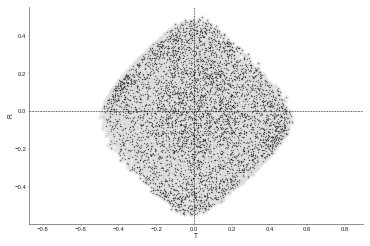

In [67]:
fig, ax = plt.subplots()
sns.scatterplot(data=gene_map, x="T", y="R",
                color="lightgrey", alpha=0.5,
                ax=ax)
# Plot the genes that were used to build the map in black
sns.scatterplot(data=gene_map.loc[param_feature_df96.columns], x="T", y="R",
                color="black", alpha=0.5, s=2,
                ax=ax)
ax.axis('equal')
ax.axvline(0, ls="--", color="black")
ax.axhline(0, ls="--", color="black")
sns.despine()
plt.savefig("outputs/gene_map.pdf", transparent=True, bbox_inches="tight")